In [1]:
# TODO craete time tracking functions
# TODO Create production capacity data
# TODO Create usage probabilities
# TODO Create economic scheme for when users purchase electricity
# TODO2 Can battery have an economic system?

# Power to the People Hackathon
## Energy System Dynamics

### Import Libraries

In [2]:
import random
import math
import numpy as np

### Set Initial Conditions

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    # total tracking of max values
    'tot_energy_prod_available': 0, # total energy produced by the system
    'tot_energy_appetite_priority': 0, # amount of energy appetite
    'tot_energy_appetite_business': 0, # amount of energy appetite
    'tot_energy_appetite_leisure': 0, # amount of energy appetite
    # total tracking of actual usage
    'tot_energy_cons_prod': 0, # total energy consumed
    'tot_energy_cons_priority': 0, # amount of energy consumed
    'tot_energy_cons_business': 0, # amount of energy consumed
    'tot_energy_cons_leisure': 0, # amount of energy consumed
    'tot_energy_cons_bat': 0,
    'tot_bat_use': 0,
    # time tracking
    'hour': 0,
    # track time-based variances
    'annual_var': 0.,
    'daily_mult': 0.8,
    # timestep energy tracking
    't_energy_prod_available': 0, # amount of energy the solartainer can produce this timestep
    # limited mechanics tracking
    'bat_level': 0, # amount of energy currently stored in the battery  
    'bat_lim': 15, # kWh
    'max_price_per_kwh': 0.13 # EUR cents
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Set Simulation Parameters

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# `M` is not currently used
simulation_parameters = {
    'T': range(5*24),
    'N': 1,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Generate Data Functions

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Specify the energy generation and usage functions

def hourly_production_capacity(params, step, sL, s):
    hour = s['hour']
    # set cosine function attributes
    y_int = 5.6 # tuned to make energy output over year match reported 59000 per Solartainer
    cos_mult = 1.5
    x_mult = 1./365/24*2*np.pi
    # get variances
    # annual
    if hour % 365 == 0:
        mu, sigma = y_int, .1 * y_int
        annual_var = np.random.normal(mu, sigma, 1)[0]
    else:
        annual_var = s['annual_var']
    # hourly var
    mu = cos_mult*np.cos(step*x_mult) + y_int + annual_var
    mu, sigma = mu, .1 * mu
    hourly_var = np.random.normal(0, sigma, 1)[0]
    # hourly mult
    hourly_mult = max(np.sin((hour)/24*2*np.pi - np.pi/2) + 0.5, 0)
    # daily (multiplier)
    if hour % 24 == 0:
        mu, sigma = 1.0, .3
        daily_mult = abs(np.random.normal(0.7, sigma, 1)[0])
    else:
        daily_mult = s['daily_mult']
    # get production output
    prod = ((cos_mult*np.cos(step*x_mult) + y_int + annual_var + hourly_var) * daily_mult) * hourly_mult
    return(prod, annual_var, daily_mult)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Specify Agent Energy Consumption Functions

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# Specify the Solartainer production and battery logic in a Policy function
def solartainer_produce(params, step, sL, s):
    # calculate production from random variables
    t_energy_prod_available, annual_var, daily_mult = hourly_production_capacity(params, step, sL, s)
    if s['hour'] % 24 == 0:
        print("day:", int(s['hour']/24), 'mult:', s['daily_mult'])
    #print('h:', s['hour'],'en:', t_energy_prod_available)
    return({'t_energy_prod_available': t_energy_prod_available,
            'annual_var_': annual_var,
            'daily_mult_': daily_mult
            })

# Specify the user of electricity logic in a Policy function
def consume_electricity(params, step, sL, s, energy_appetite, use_bat):
    energy_avail_prod = s['t_energy_prod_available']
    energy_cons_prod = min(energy_avail_prod, energy_appetite)
    if use_bat:
        energy_cons_bat = min(energy_appetite - energy_cons_prod, s['bat_level'])
    else:
        energy_cons_bat = 0
    # print(step, "app:", energy_appetite, "cons:", energy_cons_prod, "avail:", energy_cons_bat, energy_avail_prod, s['bat_level'])
    return(energy_cons_prod, energy_cons_bat)

# Specify the individual policy functions of the electricity consumers and battery
def userGroup_priority(params, step, sL, s):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite = 3 #random.random()*2
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    energy_cons = energy_cons_prod + energy_cons_bat
    return({'energy_appetite_priority': energy_appetite,
            'energy_cons_priority': energy_cons, 
            't_energy_cons_prod': energy_cons_prod, 
            't_energy_cons_bat': energy_cons_bat,
            'energy_cons_bat': 0})

def userGroup_business(params, step, sL, s):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite = 2 #random.random()*1
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    energy_cons = energy_cons_prod + energy_cons_bat
    return({'energy_appetite_business': energy_appetite,
            'energy_cons_business': energy_cons, 
            't_energy_cons_prod': energy_cons_prod, 
            't_energy_cons_bat': energy_cons_bat,
            'energy_cons_bat': 0})

def userGroup_leisure(params, step, sL, s):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite = 1 #random.random()*1
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    energy_cons = energy_cons_prod + energy_cons_bat
    return({'energy_appetite_leisure': energy_appetite,
            'energy_cons_leisure': energy_cons, 
            't_energy_cons_prod': energy_cons_prod, 
            't_energy_cons_bat': energy_cons_bat,
            'energy_cons_bat': 0})

# Specify the actions of the battery based on leftover electricity
def battery_tracker(params, step, sL, s):
    # calculate energy appetite based on battery cap
    energy_appetite = s['bat_lim'] - s['bat_level']
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=False)
    return({'t_energy_cons_prod': energy_cons_prod,
            'energy_cons_bat': energy_cons_prod,
            't_energy_cons_bat': 0,
            'hour_inc': 1})

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

### Define State Update Functions

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the amount of electricity produced / consumed

# update potential max values
def increment_tot_energy_prod_available(params, step, sL, s, _input):
    y = 'tot_energy_prod_available'
    x = s['tot_energy_prod_available'] + _input['t_energy_prod_available']
    return (y, x)

def set_t_energy_prod_available(params, step, sL, s, _input):
    y = 't_energy_prod_available'
    x = _input['t_energy_prod_available']
    return (y, x)

def increment_t_energy_prod_available(params, step, sL, s, _input):
    y = 't_energy_prod_available'
    x = s['t_energy_prod_available'] - _input['t_energy_cons_prod']
    return (y, x)

def increment_tot_energy_appetite_priority(params, step, sL, s, _input):
    y = 'tot_energy_appetite_priority'
    x = s['tot_energy_appetite_priority'] + _input['energy_appetite_priority']
    return (y, x)

def increment_tot_energy_appetite_business(params, step, sL, s, _input):
    y = 'tot_energy_appetite_business'
    x = s['tot_energy_appetite_business'] + _input['energy_appetite_business']
    return (y, x)

def increment_tot_energy_appetite_leisure(params, step, sL, s, _input):
    y = 'tot_energy_appetite_leisure'
    x = s['tot_energy_appetite_leisure'] + _input['energy_appetite_leisure']
    return (y, x)

# update actual use values
def increment_tot_energy_cons_prod(params, step, sL, s, _input):
    y = 'tot_energy_cons_prod'
    x = s['tot_energy_cons_prod'] + _input['t_energy_cons_prod']
    return (y, x)

def increment_tot_energy_cons_priority(params, step, sL, s, _input):
    y = 'tot_energy_cons_priority'
    x = s['tot_energy_cons_priority'] + _input['energy_cons_priority']
    return (y, x)

def increment_tot_energy_cons_business(params, step, sL, s, _input):
    y = 'tot_energy_cons_business'
    x = s['tot_energy_cons_business'] + _input['energy_cons_business']
    return (y, x)

def increment_tot_energy_cons_leisure(params, step, sL, s, _input):
    y = 'tot_energy_cons_leisure'
    x = s['tot_energy_cons_leisure'] + _input['energy_cons_leisure']
    return (y, x)

# update tot battery usage
def increment_tot_bat_use(params, step, sL, s, _input):
    y = 'tot_bat_use'
    x = s['tot_bat_use'] + _input['t_energy_cons_bat']
    return (y, x)

# update battery state
def increment_bat_level(params, step, sL, s, _input):
    y = 'bat_level'
    x = s['bat_level'] - _input['t_energy_cons_bat'] + _input['energy_cons_bat']
    return (y, x)

# update input variances
def update_annual_var(params, step, sL, s, _input):
    y = 'annual_var'
    x = _input['annual_var_']
    return (y, x)

def update_daily_mult(params, step, sL, s, _input):
    y = 'daily_mult'
    x = _input['daily_mult_']
    return (y, x)

# update tracker of hours passed
def increment_hour(params, step, sL, s, _input):
    y = 'hour'
    x = s['hour'] + _input['hour_inc']
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Define Partial State Update Blocks

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { # Get energy available to be used in this timestep
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'solartainer_produce': solartainer_produce
        },
        'variables': { # The following state variables will be updated simultaneously
            't_energy_prod_available': set_t_energy_prod_available,
            'tot_energy_prod_available': increment_tot_energy_prod_available,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult
        }
    },
    { # Get priority users usage (Tier 1 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_priority': userGroup_priority
        },
        'variables': { # The following state variables will be updated simultaneously
            'tot_energy_appetite_priority': increment_tot_energy_appetite_priority,
            'tot_energy_cons_prod': increment_tot_energy_cons_prod,
            'tot_energy_cons_priority': increment_tot_energy_cons_priority,
            'tot_bat_use': increment_tot_bat_use,
            'bat_level': increment_bat_level,
            't_energy_prod_available': increment_t_energy_prod_available
        }
    },
    { # Get business users usage (Tier 2 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_business': userGroup_business
        },
        'variables': { # The following state variables will be updated simultaneously
            'tot_energy_appetite_business': increment_tot_energy_appetite_business,
            'tot_energy_cons_prod': increment_tot_energy_cons_prod,
            'tot_energy_cons_business': increment_tot_energy_cons_business,
            'tot_bat_use': increment_tot_bat_use,
            'bat_level': increment_bat_level,
            't_energy_prod_available': increment_t_energy_prod_available
        }
    },
    { # Get leisure users usage (Tier 3 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_leisure': userGroup_leisure
        },
        'variables': { # The following state variables will be updated simultaneously
            'tot_energy_appetite_leisure': increment_tot_energy_appetite_leisure,
            'tot_energy_cons_prod': increment_tot_energy_cons_prod,
            'tot_energy_cons_leisure': increment_tot_energy_cons_leisure,
            'tot_bat_use': increment_tot_bat_use,
            'bat_level': increment_bat_level,
            't_energy_prod_available': increment_t_energy_prod_available
        }
    },
    { # Get battery usage (Tier 4)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'battery_tracker': battery_tracker
        },
        'variables': { # The following state variables will be updated simultaneously
            'tot_energy_cons_prod': increment_tot_energy_cons_prod,
            'bat_level': increment_bat_level,
            't_energy_prod_available': increment_t_energy_prod_available,
            'hour': increment_hour
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Run cadCAD

In [9]:
from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x000001BE94D93898>]
Configurations: [<cadCAD.configuration.Configuration object at 0x000001BE94D93898>]
day: 0 mult: 0.8
day: 1 mult: 0.7499704352085591
day: 2 mult: 0.4755146273769596
day: 3 mult: 0.42968066130839944
day: 4 mult: 0.8232630819577484


### Plot Some Stuff

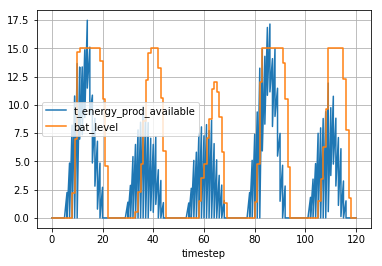

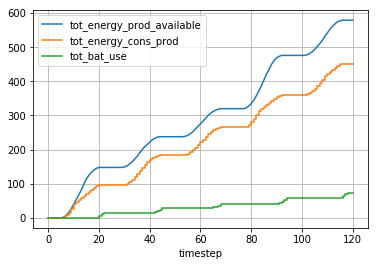

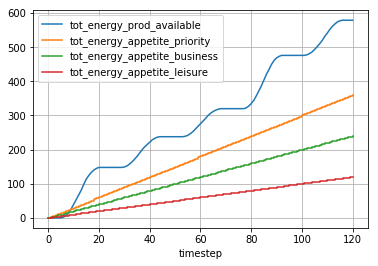

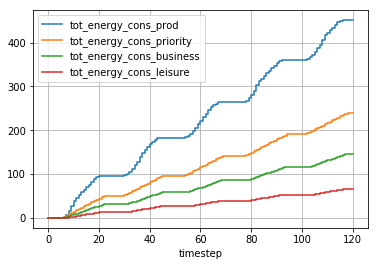

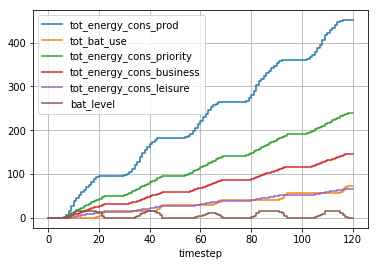

In [10]:
df.plot('timestep', ['t_energy_prod_available', 'bat_level'], grid=True);
df.plot('timestep', ['tot_energy_prod_available', 'tot_energy_cons_prod', 'tot_bat_use'], grid=True);
df.plot('timestep', ['tot_energy_prod_available', 'tot_energy_appetite_priority', 'tot_energy_appetite_business', 'tot_energy_appetite_leisure'], grid=True);
df.plot('timestep', ['tot_energy_cons_prod', 'tot_energy_cons_priority', 'tot_energy_cons_business', 'tot_energy_cons_leisure'], grid=True);
df.plot('timestep', ['tot_energy_cons_prod', 'tot_bat_use', 'tot_energy_cons_priority', 'tot_energy_cons_business', 'tot_energy_cons_leisure', 'bat_level'], grid=True);

110897.41542807834


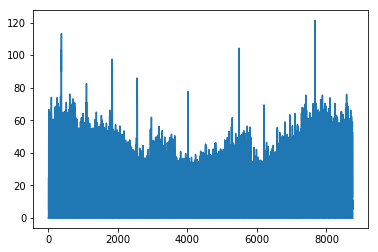

In [11]:
import math
import numpy as np
def hourly_production_capacity(params, step, sL, s):
    hour = step
    # set cosine function attributes
    y_int = 5.6
    cos_mult = 1.5
    x_mult = 1./365/24*2*np.pi
    # get variances
    # annual
    if hour % 365 == 0:
        mu, sigma = y_int, .1 * y_int
        annual_var = np.random.normal(mu, sigma, 1)[0]
    else:
        annual_var = s['annual_var']
    # hourly var
    mu = cos_mult*np.cos(step*x_mult) + y_int + annual_var
    mu, sigma = mu, .1 * mu
    hourly_var = np.random.normal(0, sigma, 1)[0]
    # hourly mult
    hourly_mult = max(np.sin((hour)/24*2*np.pi - np.pi/2) + 0.5, 0)
    # daily (multiplier)
    if hour % 24 == 0:
        mu, sigma = 1.0, .3
        daily_mult = abs(np.random.normal(0.7, sigma, 1)[0])
    else:
        daily_mult = s['daily_mult']
    # get production output
    prod = ((cos_mult*np.cos(step*x_mult) + y_int + annual_var + hourly_var) * daily_mult) * hourly_mult
    return(prod, annual_var, daily_mult)

prods = []
s = {
    'daily_mult': 1.,
    'annual_var': 0.
}
for x in range(0, 24*365):
    prod, daily_mult, annual_var = hourly_production_capacity(None, x, None, s)
    s['daily_mult'] = daily_mult
    s['annual_var'] = annual_var
    prods.append(prod)
    
print(sum(prods))
    
import matplotlib.pyplot as plt

plt.plot(prods)
plt.show()